# Introduction

Dans ce troisième notebook, On simule la dégradation de la qualité du modèle de segmentation au cours du temps, en enlevant progressivement des données (commandes) par semaine puis par mois. Afin de proposer un contrat de maintenance du modèle est préciser la fréquence à laquelle le modèle doit être mis à jour.

In [12]:
# Librairies personnalisées
from my_functions.common_functions import *
from my_functions.machine_learning_common_functions import *
from my_functions.dimensionality_reduction_functions import *
import umap
from sklearn.cluster import  KMeans, MiniBatchKMeans,BisectingKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline
low_memory=False # faible mémoire vive (RAM) pour gérer la lecture de gros fichiers

In [13]:
data = pd.read_csv('olist.csv', low_memory=low_memory)
# data = pd.read_csv('olist_umaped.csv', low_memory=low_memory)
orders_freshness = pd.read_csv('orders_freshness.csv', low_memory=low_memory)

## Stabilité Temporelle

Joindre la date des commandes au data set et le réordonner par ordre croissant de la date.

In [14]:
dft = pd.merge(data, orders_freshness[['customer_unique_id', 'timestamp']], how='inner', on=['customer_unique_id'])
# dft = data.copy().iloc[:,1:]
dft['timestamp'] = pd.to_datetime(dft['timestamp'], infer_datetime_format=True)
dft = dft.sort_values(by='timestamp').reset_index(level=0)
dft

,index,customer_unique_id,Freshness(R),multi_orders(F),payment_value(M),review_score(S),daytime,weekday,month,orders_volume,payment_sequential,payment_installments,pcateg,customer_state,payment_type,timestamp
0,17011,2f64e403852e6893ae37485d5fcacdaf,0.000000,0,1.0,4,3.0,6.0,1.0,1,1,1,61.0,1.0,2.0,2016-10-03 16:56:50
1,35094,61db744d2f835035a5625b59350c6b63,0.000257,0,1.0,3,2.0,6.0,1.0,1,1,1,61.0,1.0,2.0,2016-10-03 21:13:36
2,50378,8d3a54507421dbd2ce0a1d58046826e0,0.000309,0,2.0,1,2.0,6.0,1.0,1,1,6,59.0,5.0,3.0,2016-10-03 22:06:03
3,48431,87776adb449c551e74c13fc34f036105,0.000334,0,1.0,5,2.0,6.0,1.0,1,1,4,27.0,5.0,3.0,2016-10-03 22:31:31
4,41385,7390ed59fa1febbfda31a80b4318c8cb,0.000347,0,2.0,5,2.0,6.0,1.0,1,1,2,53.0,4.0,3.0,2016-10-03 22:44:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91471,43694,7a22d14aa3c3599238509ddca4b93b01,0.999845,0,1.0,1,3.0,4.0,11.0,1,1,7,53.0,5.0,3.0,2018-08-29 12:25:59
91472,33143,5c58de6fb80e93396e2f35642666b693,0.999958,0,2.0,5,3.0,4.0,11.0,2,1,8,30.0,0.0,3.0,2018-08-29 14:18:23
91473,45801,7febafa06d9d8f232a900a2937f04338,0.999958,0,1.0,5,3.0,4.0,11.0,1,1,1,62.0,2.0,1.0,2018-08-29 14:18:28
91474,65484,b701bebbdf478f5500348f03aff62121,0.999991,0,1.0,3,3.0,4.0,11.0,1,1,1,6.0,5.0,3.0,2018-08-29 14:52:00


In [4]:
scale = 'std'
hue = 'umaped'
best_k = 4
# hue = 'df'
display_components=0 # <1 aucun diplay, 3 display 3D, sinon display 2D sur le nombre de composantes choisies
projection = None
scores = ['Calinski-Harabasz(Var)', 'Davies-Bouldin(Sim)', 'Silhouette']

### Par Semaines

In [5]:
Perfs_weeks = pd.DataFrame(columns=['Model']+scores, index=[])

kmeans_weeks = []
nb_weeks = 16
for i in range(nb_weeks):
    data = dft[dft['timestamp'].max()-dft['timestamp']>pd.Timedelta(7*i, 'd')].iloc[:, 1:-1]
    data = pd.DataFrame(ManifoldReduction3D(data, manifold = umap.UMAP(n_neighbors=100, min_dist=0.0, metric='minkowski', n_components=3)), columns=['C1', 'C2', 'C3'])
    cls = clustering(data, MiniBatchKMeans(n_clusters=best_k, init='k-means++', tol=0.001, batch_size = 2048), 'MiniBatchKMeans++('+str(i)+')', projection, Perfs_weeks, scale=scale, scores=scores, hue=hue, display_components=display_components)
    kmeans_weeks.append(cls)

-------------------- KMeans++(0) --------------------
Model                       KMeans++(0)
Calinski-Harabasz(Var)    138274.425995
Davies-Bouldin(Sim)            0.805907
Silhouette                     0.629908
Time(s)                        0.836725
hue                              umaped
Name: 0, dtype: object
-------------------- KMeans++(1) --------------------
Model                      KMeans++(1)
Calinski-Harabasz(Var)    123714.53982
Davies-Bouldin(Sim)           0.783019
Silhouette                    0.632554
Time(s)                       0.542678
hue                             umaped
Name: 1, dtype: object
-------------------- KMeans++(2) --------------------
Model                       KMeans++(2)
Calinski-Harabasz(Var)    130716.548134
Davies-Bouldin(Sim)            0.635825
Silhouette                      0.64419
Time(s)                        0.610813
hue                              umaped
Name: 2, dtype: object
-------------------- KMeans++(3) --------------------
M

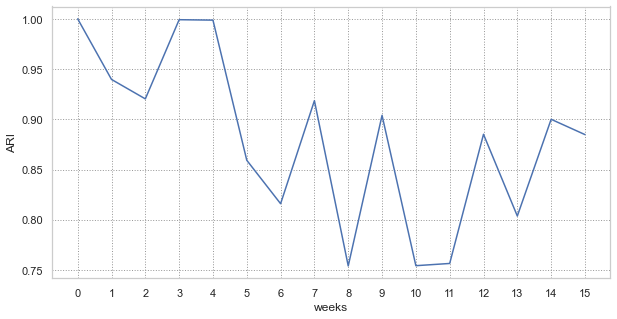

In [6]:
ARI_weeks = [adjusted_rand_score(kmeans_weeks[0].labels_[:len(kmeans_weeks[i].labels_)], kmeans_weeks[i].labels_) for i in range(nb_weeks)]
lineplot(y=ARI_weeks, x=np.arange(len(ARI_weeks)), ylabel='ARI', xlabel='weeks')

Le modèle subit une forte dégradation à partir de la 7ème semaine, de données en moins.

### Par Mois

In [8]:
Perfs_months = pd.DataFrame(columns=['Model']+scores, index=[])

kmeans_months = []
nb_months = 10
for i in range(nb_months):
    data = dft[dft['timestamp'].max()-dft['timestamp']>pd.Timedelta(30*i, 'd')].iloc[:, 1:-1]
    data = pd.DataFrame(ManifoldReduction3D(data, manifold = umap.UMAP(n_neighbors=100, min_dist=0.0, metric='minkowski', n_components=3)), columns=['C1', 'C2', 'C3'])
    cls = clustering(data, MiniBatchKMeans(n_clusters=best_k, init='k-means++', tol=0.001, batch_size = 2048), 'MiniBatchKMeans++('+str(i)+')', projection, Perfs_months, scale=scale, scores=scores, hue=hue, display_components=display_components)
    kmeans_months.append(cls)

-------------------- KMeans++(0) --------------------
Model                       KMeans++(0)
Calinski-Harabasz(Var)    139846.324845
Davies-Bouldin(Sim)            0.681969
Silhouette                      0.62203
Time(s)                        0.659906
hue                              umaped
Name: 0, dtype: object
-------------------- KMeans++(1) --------------------
Model                       KMeans++(1)
Calinski-Harabasz(Var)    129521.092317
Davies-Bouldin(Sim)             0.84722
Silhouette                     0.632778
Time(s)                         0.53293
hue                              umaped
Name: 1, dtype: object
-------------------- KMeans++(2) --------------------
Model                       KMeans++(2)
Calinski-Harabasz(Var)    122184.385292
Davies-Bouldin(Sim)            0.717211
Silhouette                     0.635895
Time(s)                        0.551669
hue                              umaped
Name: 2, dtype: object
-------------------- KMeans++(3) ----------------

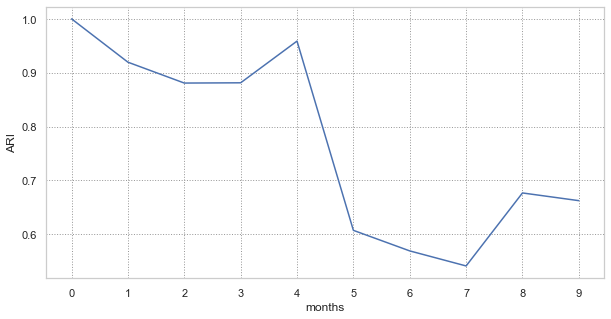

In [9]:
ARI_months = [adjusted_rand_score(kmeans_months[0].labels_[:len(kmeans_months[i].labels_)], kmeans_months[i].labels_) for i in range(nb_months)]
lineplot(y=ARI_months, x=np.arange(len(ARI_months)), ylabel='ARI', xlabel='months')

<p>Le modèle subit une forte dégradation à partir du 2ème mois, de données en moins. Ce qui est cohérent avec le résultat précédent (7semaine=2mois).</p>
<p>En conclusion, le modèle doit mis à jour chaque 2 mois en le réexécutant avec les nouvelles données pour produire une segmentation plus fidèle aux nouvelles données.</p>